# Optimising Ilic-Style Grating for Transverse Damping

Here, I will optimise the Ilic-style grating for transverse damping. I will initialise my optimisation problem with the Ilic grating. The goal is then to optimise for the width and position of the two elements in the Ilic-style grating. However, GRCWA uses spatial discretisation. Therefore I cannot directly compute gradients of a cost function with respect to the discrete width or position of the elements. Instead, the method is as follows:

1. When the unit cell is considered, it is sliced into Nx discrete components. While the width of the geometry is continuously defined outside of the code, it must be discretised within the code. We do this by effectively cutting off the boundary of each cell element, so that the element's width completely fills each slice. The slices on the boundary of the element which are partially filled will not be considered as part of the element.

2. To account for the partially-filled slices, I will instead change the permittivity of the element within that slice. Rather than ignoring the partially filled slices, I will add these slices as part of the cell element, but with a different permittivity. Since the elements have a permittivity of $\varepsilon_{Si} = 12$, and the substrate has permittivity $\varepsilon_{SiO_2} = 1$, then the adjusted permittivity of these partially filled slices will be $\varepsilon = (\varepsilon_{Si} - \varepsilon_{SiO_2})\frac{w-w_\text{filled}}{2*d/(Nx-1)}$. Here, $w_\text{filled}$ is the amount of the element which actually fills a unit cell, while $w$ is the width itself. Moreover, $\frac{d}{N_x-1}$ is the width of each slice, and the factor of 2 is there because there are two boundaries per element.

3. Optimise with respect to the changed boundary permittivities, which are continuously defined in GRCWA.


But how is this possible? Generally, GRCWA output the gradients of the cost function w.r.t. all of the permittivity values at the sliced grid points, let's call it $pCpe$. We need to manually convert the $pCpe$ into the effective derivative of the cost function with respect to width, call it $pCpw$. This will require many steps


1. Find $pCpe$ where only boundary $\varepsilon$'s are changed.

2. Find $pCpw$, given $pCpe$ from above. We have
$$
    \frac{\partial C}{\partial w} = \frac{\partial C}{\partial \varepsilon}\frac{\partial \varepsilon}{\partial w} = \frac{\varepsilon_{Si} - \varepsilon_{SiO_2}}{2\cdot d/(N_x-1)}\frac{\partial C}{\partial \varepsilon}
$$
since $w_\text{filled}$ is a step function, whose derivative is zero for the cases where this result matters.

## Creating an Optimisation Software

## Applying the Optimisation Software


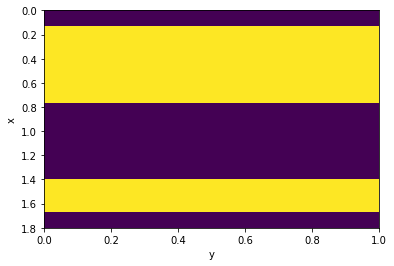

0.27 0.26999800000022867 0.49999994283789206
0.63 0.6299979999969805 0.5000007548827679


'\nProblem: the meshgrid coordinates are not edges, they are centers of bins.\n'

In [176]:
# What is w_filled?
import numpy as np
import matplotlib.pyplot as plt

Nx = 900001
Ny = 1

d = 1.8  # unit cell width
dy = 1e-1
x1 = 0.85*d # positions of blocks in unit cell
x2 = 0.25*d 
w1 = 0.15*d # width of blocks in unit cell
w2 = 0.35*d

ones = np.ones((Nx,Ny))

# Defining coordinate system
x0 = np.linspace(0,d,Nx)
y0 = np.linspace(0,dy,Ny)
x, y = np.meshgrid(x0,y0, indexing='ij')

# Need to add factor d/2*(Nx-1) as the x-positions in the meshgrid are the centers of bins, not actual bins. The bins have width d/(Nx-1)
filter = (abs(x - x1) + (d/(2*(Nx-1))) <= w1/2) | (abs(x-x2) + (d/(2*(Nx-1))) <= w2/2)
cell_geometry = np.ones((Nx,Ny))
cell_geometry[filter] = 12
# How many cells are filled?
w_filled_e1 = sum(ones[abs(x-x1) + (d/(2*(Nx-1))) <= w1/2]*d/(Nx-1))
w_filled_e2 = sum(ones[abs(x-x2) + (d/(2*(Nx-1))) <= w2/2]*d/(Nx-1))

plt.imshow(cell_geometry, interpolation='nearest', aspect='auto', extent=[0,1,d,0])
plt.xlabel("y")
plt.ylabel("x")
plt.show()
print(w1, w_filled_e1, (w1-w_filled_e1)/(2*d/(Nx-1)))
print(w2, w_filled_e2, (w2-w_filled_e2)/(2*d/(Nx-1)))